# Group 4: Project Milestone 4
### Kairan Wang, Samantha Lau, Aaryan Sharma

# Instructions / Criteria
- Highlight your final problem statement and hypothesis
- Explain your data and main features
- Highlight the main findings of your analysis
- Include your main tables and/or figures

# Introduction

## Dataset Background

The original MovieLens dataset contained 100,000 ratings (1-5) from 943 users on 1682 movies with additional information collected about users (age, gender, occupation, zip code) and movies (title, release date, genre). Each user had rated at least 20 movies. These ratings were collected over seven months from September 1997 to April 1998.

We received 5 datasets:
- data.csv containing the 100,000 ratings with the corresponding user
- movie.csv containing 1682 movies and including genre and release date information
- genre.csv containing a list of 19 genres
- user.csv containing 943 users and demographic information
- occupation.csv containing a list of occupations

The data we received had been previously cleaned to exclude users with less than 20 ratings, or those with missing information. Based on our study’s hypothesis, we performed additional data cleaning for our analysis.

## Problem Statement and Hypothesis

The problem statement for our project remained more or less the same throughout our milestones, with slight evolutions as we discovered more about our data through cleaning and visualisations.

Our final **problem statement** is: To understand how different covariates affect users’ movie preferences, in order to deliver best movie recommendations to users.

Our **hypothesis** underpinning our goal to create a movie recommender is: There is a relationship between covariates and movie preference, as measured by ratings in different genres.

Based on known ratings from the MovieLens data, we wanted to analyse which movies (based on genre) a user with certain demographic markers is likely to rate highly. From these findings, we attempted to build a **machine learning model** which would take user and movie features to output a predicted rating for any user-movie pair.  If the model is successful, then we can reject the null hypothesis (that there is no relationship between covariates and movie preference).

Our **outcome** (or target) variable is thus rating, while our **relevant variables** included age, gender, and occupation. Zip code was excluded due to issues of practicality.

# Set-up

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/ADS_Project/movielens/'

Mounted at /content/drive


# Understanding the Data

## Initial Inspection

Before making any decisions about what data we would keep or get rid of for our analysis, we began first with a preliminary inspection of the data and the main variables we were interested in for our hypothesis (namely, covariates and movie genres).

We first read in the user.csv file to understand the distribution of each of the covariates across our dataset.

In [ ]:
#read in user.csv file
dfUser = pd.read_csv(path+'user.csv',sep="\t",header = None,
                       names=["user_id", "age", "gender", "occupation", "zip_code"])

### Gender Distribution

Looking at the value count for gender highlighted that our sample was heavily skewed towards males, which was something we needed to keep in mind throughout the remaining analysis and will be touched upon in our limitations section.

In [ ]:
dfUser.value_counts('gender')

gender
M    670
F    273
dtype: int64

### Age Distribution

We then used matplotlib to plot a simple bar graph of the age distribution of users. The breakdown of the age distribution of users in this dataset demonstrated that we have enough user information from each age group, with most users found between the ages of 20-30. This gave us some insights on how to set the age group boundaries for our more comprehensive visualisations.

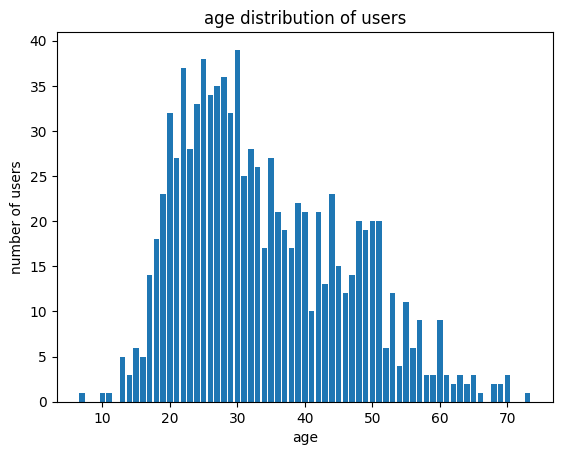

In [ ]:
ages = dfUser['age'].sort_values().unique()
users = dfUser.value_counts('age').sort_index()

plt.bar(ages,users)
plt.title('age distribution of users')
plt.xlabel('age')
plt.ylabel('number of users')

plt.show()

### Occupations

Based on our initial exploration of occupation, we did not find it to be particularly interesting when looking at our overall dataset because we found that the biggest group is students, who are going to be of certain age (typically under 24). Thus, we summised that the effect of occupation if we are looking at all of the users would probably be captured by age. However, as will be seen in the visualisation section, we returned to occupation in Milestone 2 to better understand its relationship with rating.

In [ ]:
dfUser.value_counts('occupation').sort_index()

occupation
administrator     79
artist            28
doctor             7
educator          95
engineer          67
entertainment     18
executive         32
healthcare        16
homemaker          7
lawyer            12
librarian         51
marketing         26
none               9
other            105
programmer        66
retired           14
salesman          12
scientist         31
student          196
technician        27
writer            45
dtype: int64

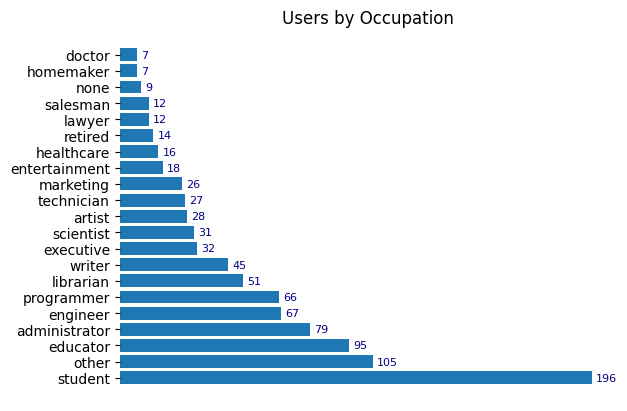

In [ ]:
occupations = dfUser.drop_duplicates('user_id').value_counts('occupation')

bars = plt.barh(occupations.index, occupations.values);
plt.bar_label(bars, fontsize = 8, padding = 3, color = 'navy');

ax = plt.gca()
ax.spines[:].set_visible(False);
ax.set_xticks([]);
ax.grid(False)
ax.set_title("Users by Occupation");
# ax.set_xlabel("Number of Genres per Movie");

### Genre Information

Besides looking at user covariates, we also needed to understand the movies in the dataset, and specifically their genres (as this is the main indicator of movie content that can impact movie ratings).

The genre.csv file provided us an overview of the 19 genres that movies could be classified as.

In [ ]:
dfGenres = pd.read_csv(path+'genre.csv',sep="\t",header = None, names=['genre_name', 'code'])
dfGenres

,genre_name,code
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


We noticed from our movies.csv file that movies could be classified as more than one genre, and we thus decided to keep the genre information as one-hot encoding, rather than extracting the genre names and combining them.

We further inspected genre after we conducted cleaning of our dataset (see below for additional note on genre).

In [ ]:
dfMovies = pd.read_csv(path+'movie.csv',sep="\t",header = None, engine='python',encoding='latin-1',
                       names=["movie_id","movie_title","video_release_date","blank","IMDb_URL","unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"])
dfMovies

,movie_id,movie_title,video_release_date,blank,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Cleaning

After conducting preliminary inspection of the data, we undertook further cleaning of the data to prepare for visualisations and preliminary analysis.

### Removing Data

We received a very clean dataset with few missing values. We removed only 2 movies that had unknown genre, totalling 10 ratings from the dataset.

We also dropped information about movies except movieid, title, release year, and genres. In anticipation of movie release date being a confounder for movie rating, we converted the original movie release date variable to datetime and extracted the year only to create a new release year column.

We kept all user covariate variables except zip code.

### Merging

Following data removal on the separate datasets provided, we combined user information with ratings. Our final dataframe had 99990 rows each corresponding to an entry. User information was thus repeated for each of the movies the user had rated.

The final dataframe had 26 columns - 3 covariates, 19 genres, 3 variables for movie information (id, title, release year) and 1 rating variable.

In [ ]:
# Cleaned dataset after Milestone 1
df = pd.read_csv(path+'MS1.csv',index_col=[0])
df

,user_id,movie_id,rating,age,gender,occupation,movie_title,Action,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,196,242,3,49,M,writer,Kolya (1996),0,0,0,...,0,0,0,0,0,0,0,0,0,1997.0
1,186,302,3,39,F,executive,L.A. Confidential (1997),0,0,0,...,1,0,0,1,0,0,1,0,0,1997.0
2,22,377,1,25,M,writer,Heavyweights (1994),0,0,0,...,0,0,0,0,0,0,0,0,0,1994.0
3,244,51,2,28,M,technician,Legends of the Fall (1994),0,0,0,...,0,0,0,0,1,0,0,1,1,1994.0
4,166,346,1,47,M,educator,Jackie Brown (1997),0,0,0,...,0,0,0,0,0,0,0,0,0,1997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,13,M,student,"First Wives Club, The (1996)",0,0,0,...,0,0,0,0,0,0,0,0,0,1996.0
99996,716,204,5,36,F,administrator,Back to the Future (1985),0,0,0,...,0,0,0,0,0,1,0,0,0,1985.0
99997,276,1090,1,21,M,student,Sliver (1993),0,0,0,...,0,0,0,0,0,0,1,0,0,1993.0
99998,13,225,2,47,M,educator,101 Dalmatians (1996),0,0,0,...,0,0,0,0,0,0,0,0,0,1996.0


## Additional Note on Genre

After cleaning our data and removing all movies with missing title or genre, we returned to genre. We wanted to get a sense of the distribution of movies across genres - both how many genres each movie has as well as which genres have the most movies in them.

In [ ]:
#create copy of original dataframe with movie title and genres per movie
df_unique_movies = df[df.columns[6:-1]].copy().drop_duplicates('movie_title')

#add column for sum of genres per movie
df_unique_movies['no_genres'] = df_unique_movies[df_unique_movies.columns[1:]].sum(axis=1)

df_unique_movies['no_genres']

0        1
1        4
2        2
3        4
4        2
        ..
96444    1
97649    1
98427    1
98640    1
98955    1
Name: no_genres, Length: 1662, dtype: int64

In [ ]:
df_unique_movies['no_genres'].describe()

count    1662.000000
mean        1.721420
std         0.869587
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: no_genres, dtype: float64

These figures showed that we have 1662 unique movie titles. Every movie has at least 1 genre, and the most genres a movie has is 6. The mean number of genres per movie is 1.7, so we would expect that we would have mostly movies with 1 genre but enough with more to bump up the mean. Value counts shows us the frequency of each number of genres.

In [ ]:
df_unique_movies['no_genres'].value_counts()

1    822
2    563
3    212
4     51
5     11
6      3
Name: no_genres, dtype: int64

To better visualise the information, we plotted these counts as a histogram.

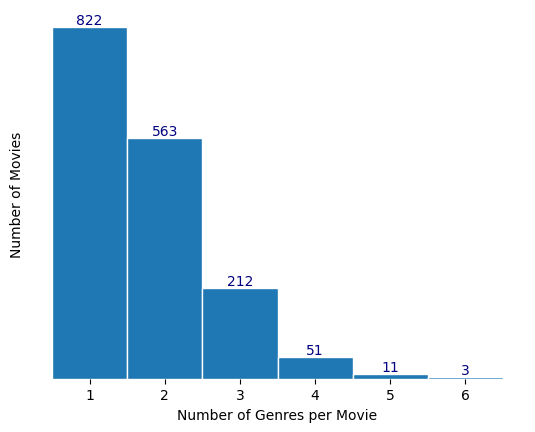

In [ ]:
bins = np.arange(1,8)-0.5
values, bins, bars = plt.hist(df_unique_movies['no_genres'], bins, edgecolor='white');
plt.bar_label(bars, color='navy');


ax = plt.gca()
ax.spines[:].set_visible(False);
ax.set_yticks([]);
ax.grid(False)
ax.set_ylabel("Number of Movies");
ax.set_xlabel("Number of Genres per Movie");

We also wanted to understand which genres our movies were distributed across, to know what sample size we would be working with if we were breaking our analysis down by genre. However, because movies could be classified as multiple genres (as seen above), we wanted to this distribution if we counted only the movies with 1 genre, as opposed to counting each movie in the sample for each genre that it is classified as.

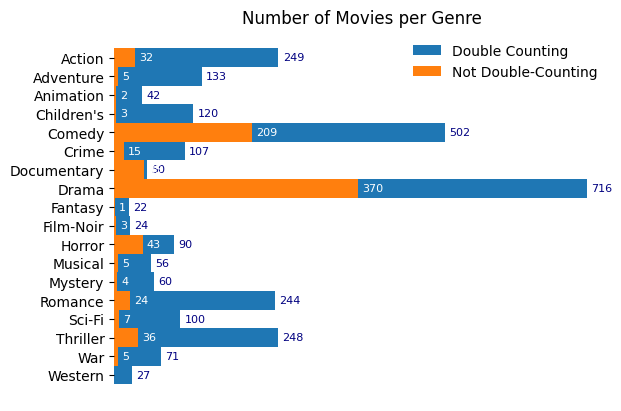

In [ ]:
def get_genre(row):
    return(row.index[row.apply(lambda x: x==1)])

df_unique_movies['genre_string'] = (df_unique_movies[["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]]
                     .apply(lambda row:get_genre(row), axis=1).str.join(' and '))

movies_by_genre = df_unique_movies[df_unique_movies.columns[1:-2]].sum().sort_index(ascending=False) #getting the sum of each genre column in our dataframe

movie_genre_categories_all = df_unique_movies.groupby('genre_string').count().sort_values('movie_title', ascending=False)[['movie_title']]
movie_genre_categories_single = movie_genre_categories_all.loc[df.columns[7:-2]].sort_index(ascending=False) #return rows for single genres only, pulled from genre columns of original dataframe

bars1 = plt.barh(movies_by_genre.index, movies_by_genre.values, height=1);
plt.bar_label(bars1, fontsize = 8, padding = 3, color = 'navy');

bars2 = plt.barh(movie_genre_categories_single.index, movie_genre_categories_single.movie_title, height=1);
plt.bar_label(bars2, fontsize = 8, padding = 3, color = 'white');
plt.legend(['Double Counting', 'Not Double-Counting'], frameon=False, fontsize=10)

ax = plt.gca()
ax.spines[:].set_visible(False);
ax.set_xticks([]);
ax.grid(False)
ax.set_title("Number of Movies per Genre");

At the time we thought this double-counting might constitute a problem for our hypothesis, but we later addressed this limitation in our model (as we will describe later).

## Visualisation and Prelim Analysis

While we did create some visualisations to better understand our main variables individually, we have included those visualisations in the previous sections of this notebook. The bulk of this visualisation stage was thus spent on visualising and beginning to analyse the relationship between covariate variables and ratings. This stage would provide us further insights to guide us on Milestone 3, when we were to begin feature engineering to build our prediction model.

### Gender and Rating

Based on our barplots and t-tests, it does seem that there is a statistically significant difference between ratings by males and females for certain genres. However, adding the error bars suggests that this may not be as sound a conclusion.

<ipython-input-18-46dad638ca12>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  heights = df[df[genre]==1].groupby('gender').mean()['rating']
<ipython-input-18-46dad638ca12>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  heights = df[df[genre]==1].groupby('gender').mean()['rating']
<ipython-input-18-46dad638ca12>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  heights = df[df[genre]==1].groupby('gender').mean()

Text(0.5, 0.98, 'Female, Male')

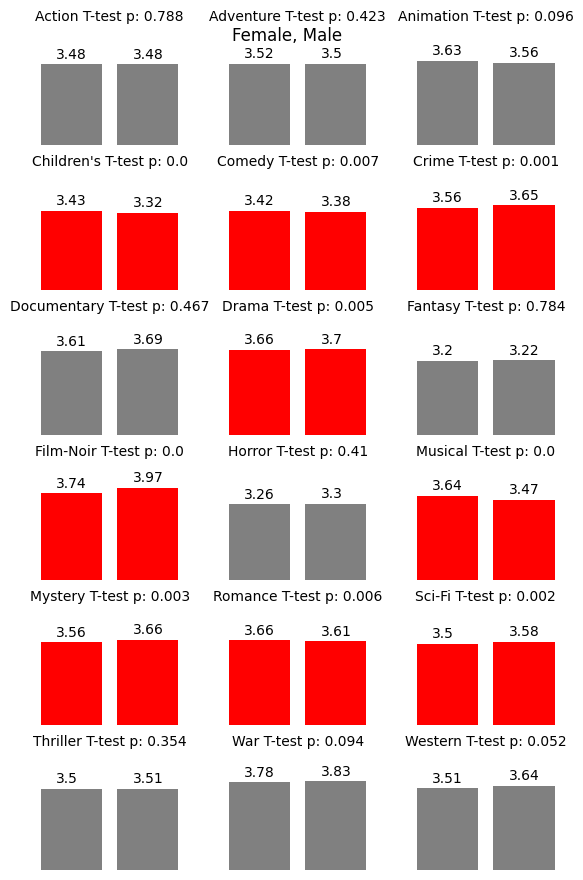

In [ ]:
plt.subplots(6,3,figsize=(6,9), sharex=True, sharey=True)
plt.tight_layout()

for count, genre in enumerate(df.columns[7:-1]):
  ax = plt.subplot(6,3,count+1)
  labels = ['F','M']
  subset = df[df[genre]==1]
#T-test
  m_ratings = subset[subset['gender']=='M']['rating'].reset_index(drop=True)
  f_ratings = subset[subset['gender']=='F']['rating'].reset_index(drop=True)

  tTest = stats.ttest_ind(m_ratings,f_ratings,equal_var=False)
  pval = tTest.pvalue.round(3)
#Bar plot
  heights = df[df[genre]==1].groupby('gender').mean()['rating']
  if pval<0.05:
    huw = 'red'
  else:
    huw = 'gray'
  ax.bar(labels,heights,color=huw)
  ax.spines[:].set_visible(False);
  ax.set_xticks([]);
  ax.set_yticks([]);

  for i, height in enumerate(heights):
      ax.text(i-0.2, height+0.25, str(round(height, 2)), fontsize=10)


  plt.title(genre+' T-test p: '+str(pval), fontsize=10)
  plt.ylim((0,5))

plt.suptitle('Female, Male')

### Age and Rating

We treated age as a numerical value to see if there is a correlation between the age of users and the ratings given by the users. We see a moderate positive correlation between age and user rating, with a small p-value.

Including the sample size of each age value in the visualization also shows us the significant of each age datapoint, showing us again that most reviews are by individuals in the 20-30 age range.

<Figure size 640x480 with 0 Axes>

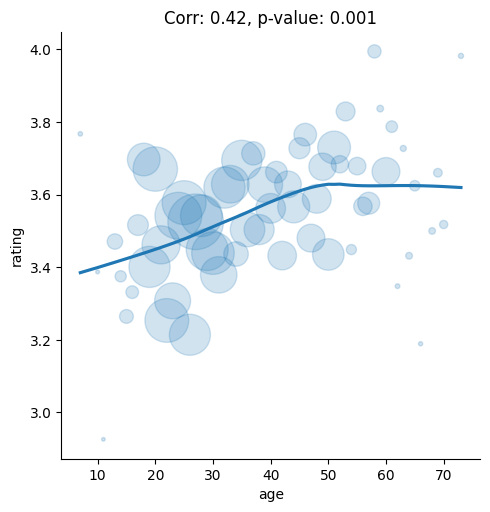

In [ ]:
df_age = df[['age','rating']].groupby('age').mean().reset_index()
df_age['number of ratings'] = list(df[['age','rating']].groupby('age').size())

df_age

# Calculate the correlation coefficient and p-value
corr, pval = stats.pearsonr(df_age['age'], df_age['rating'])

# Visualize the number of ratings from a certain age value as well
plt.figure()
sns.lmplot(data=df_age, x='age', y='rating', lowess=True,
           scatter_kws={'alpha': 0.2,'s': df_age['number of ratings']}, markers='.');
plt.title(f'Corr: {corr:.2f}, p-value: {pval:.3f}');

### Occupation and Rating

We then examine the relationship between occupation and rating, and like with gender find some statistically significant differences between ratings by the different occupations.

<ipython-input-21-13cc6b2b68c9>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped_occupation = (df.groupby(['user_id', 'occupation']+genre).mean()
<ipython-input-21-13cc6b2b68c9>:14: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i,(group,frame) in enumerate(df_grouped_occupation.groupby(['occupation'])):
<ipython-input-21-13cc6b2b68c9>:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,6,i+1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:3861: Degenerate

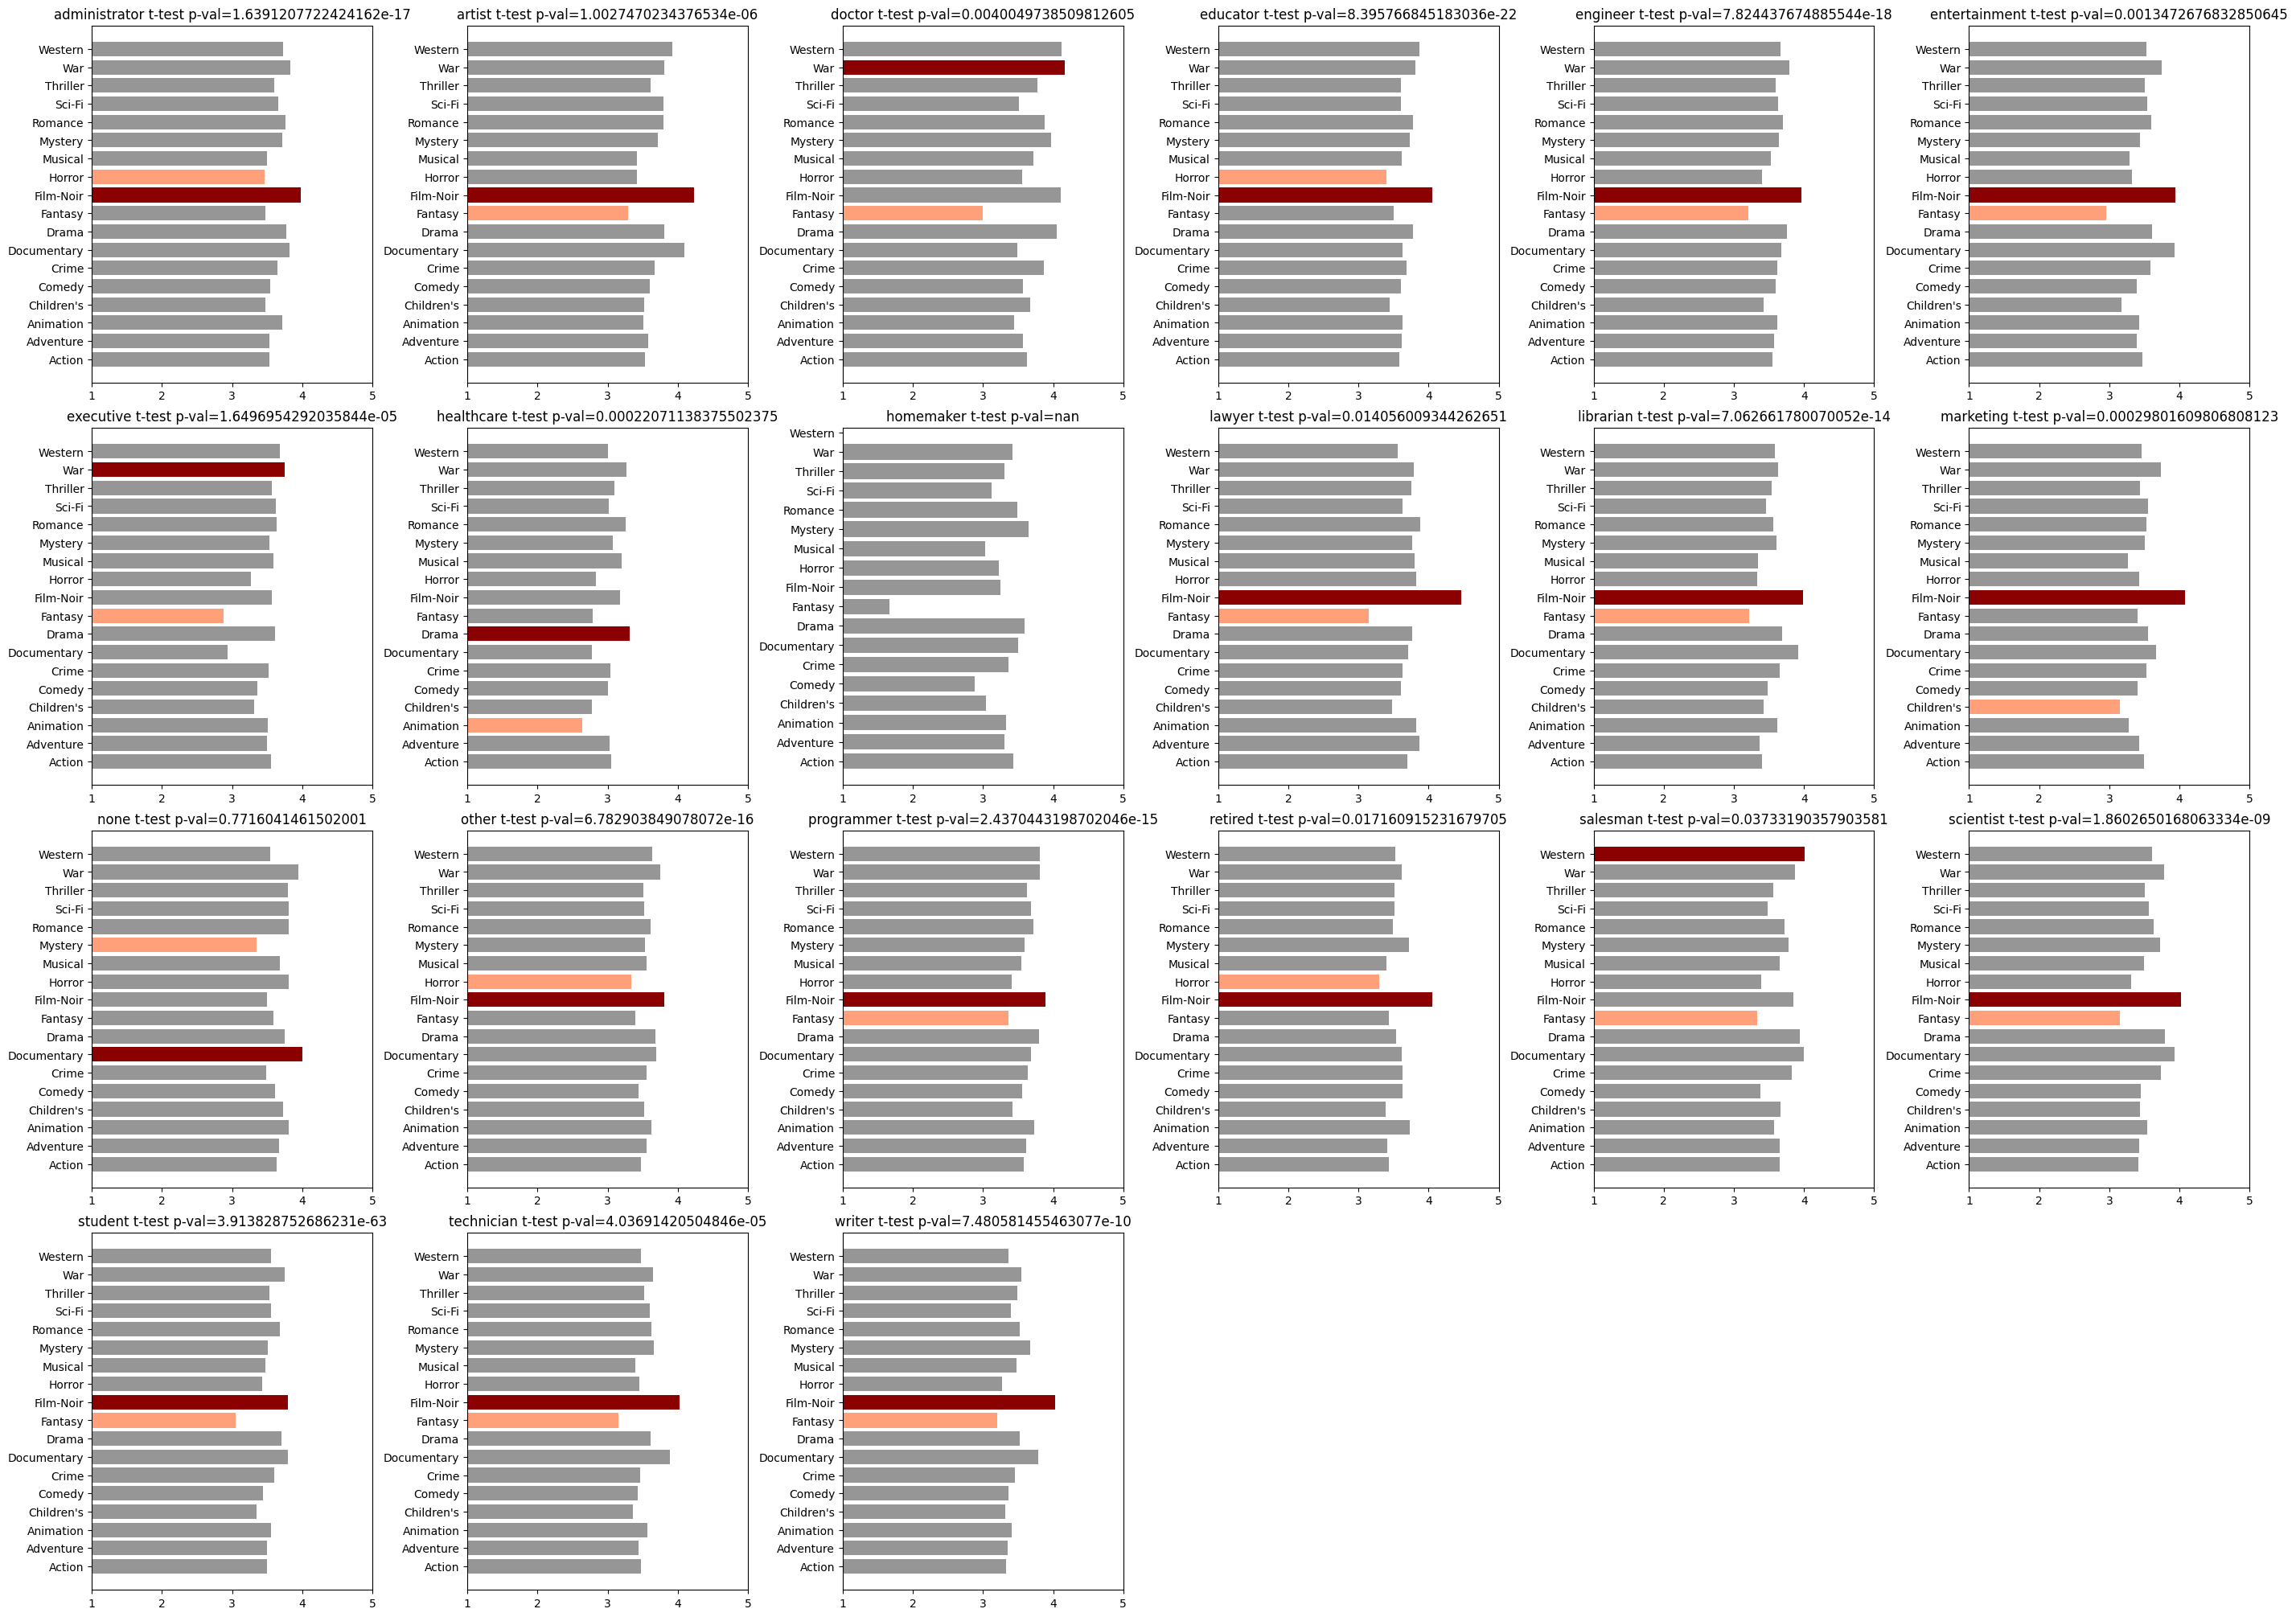

In [ ]:
from scipy.stats import f_oneway

genre = ["Action","Adventure","Animation","Children's","Comedy","Crime",
         "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical",
         "Mystery","Romance","Sci-Fi","Thriller","War","Western"]

df.sort_values(by='user_id')[['user_id','rating','occupation']+genre].head()

df_grouped_occupation = (df.groupby(['user_id', 'occupation']+genre).mean()
                .reset_index()[['user_id', 'occupation', 'rating']+genre])

fig, axes = plt.subplots(figsize=(28,20), constrained_layout=True)

for i,(group,frame) in enumerate(df_grouped_occupation.groupby(['occupation'])):
  mean=[]
  occupation_list = []
  for g in genre:
    mean.append(frame[frame[g]==1]['rating'].mean())
    occupation_list.append(frame[frame[g]==1]['rating'].reset_index(drop=True))

  anova_test = f_oneway(occupation_list[0],occupation_list[1],occupation_list[2],occupation_list[3],occupation_list[4],occupation_list[5],occupation_list[6],occupation_list[7],occupation_list[8],occupation_list[9],occupation_list[10],occupation_list[11],occupation_list[12],occupation_list[13],occupation_list[14],occupation_list[15],occupation_list[16],occupation_list[17])

  plt.subplot(4,6,i+1)

  colors = ["#969696" for i in range(len(genre))]

  # find the index of the maximum and minimum value
  max_idx = np.argmax(mean)
  min_idx = np.argmin(mean)

  # set the color of the maximum and minimum bars
  colors[max_idx] = '#8B0000'  # dark red
  colors[min_idx] = '#FFA07A'  # light red

  # since the genre labels are long, it makes more sense to use horizontal bars here
  plt.barh(genre,mean,color=colors)

  plt.xlim(1,5)
  plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
  plt.title(group+' t-test p-val='+str(anova_test.pvalue))

### Gender + Age and Rating

We also tried combining the covariates of age and gender together and then testing for a relationship with rating. To do so, we needed to make age into a categorical variable, the process for which we explained in Milestone 3.

In [ ]:
#Age: user breakdown

# dividing into groups
def age_group(age):
  if age<18:
    return "Under 18"
  elif 18<=age<=24:
    return "18-24"
  elif 25<=age<=34:
    return "25-34"
  elif 35<=age<=44:
    return "35-44"
  elif 45<=age<=55:
    return "45-55"
  elif 55<age:
    return "Over 55"

df['age_range'] = df['age'].apply(age_group)

<ipython-input-28-2b4518e62e8e>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = (df.groupby(['user_id', 'gender', 'age_range']+genre).mean()
<ipython-input-28-2b4518e62e8e>:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,6,i+1)


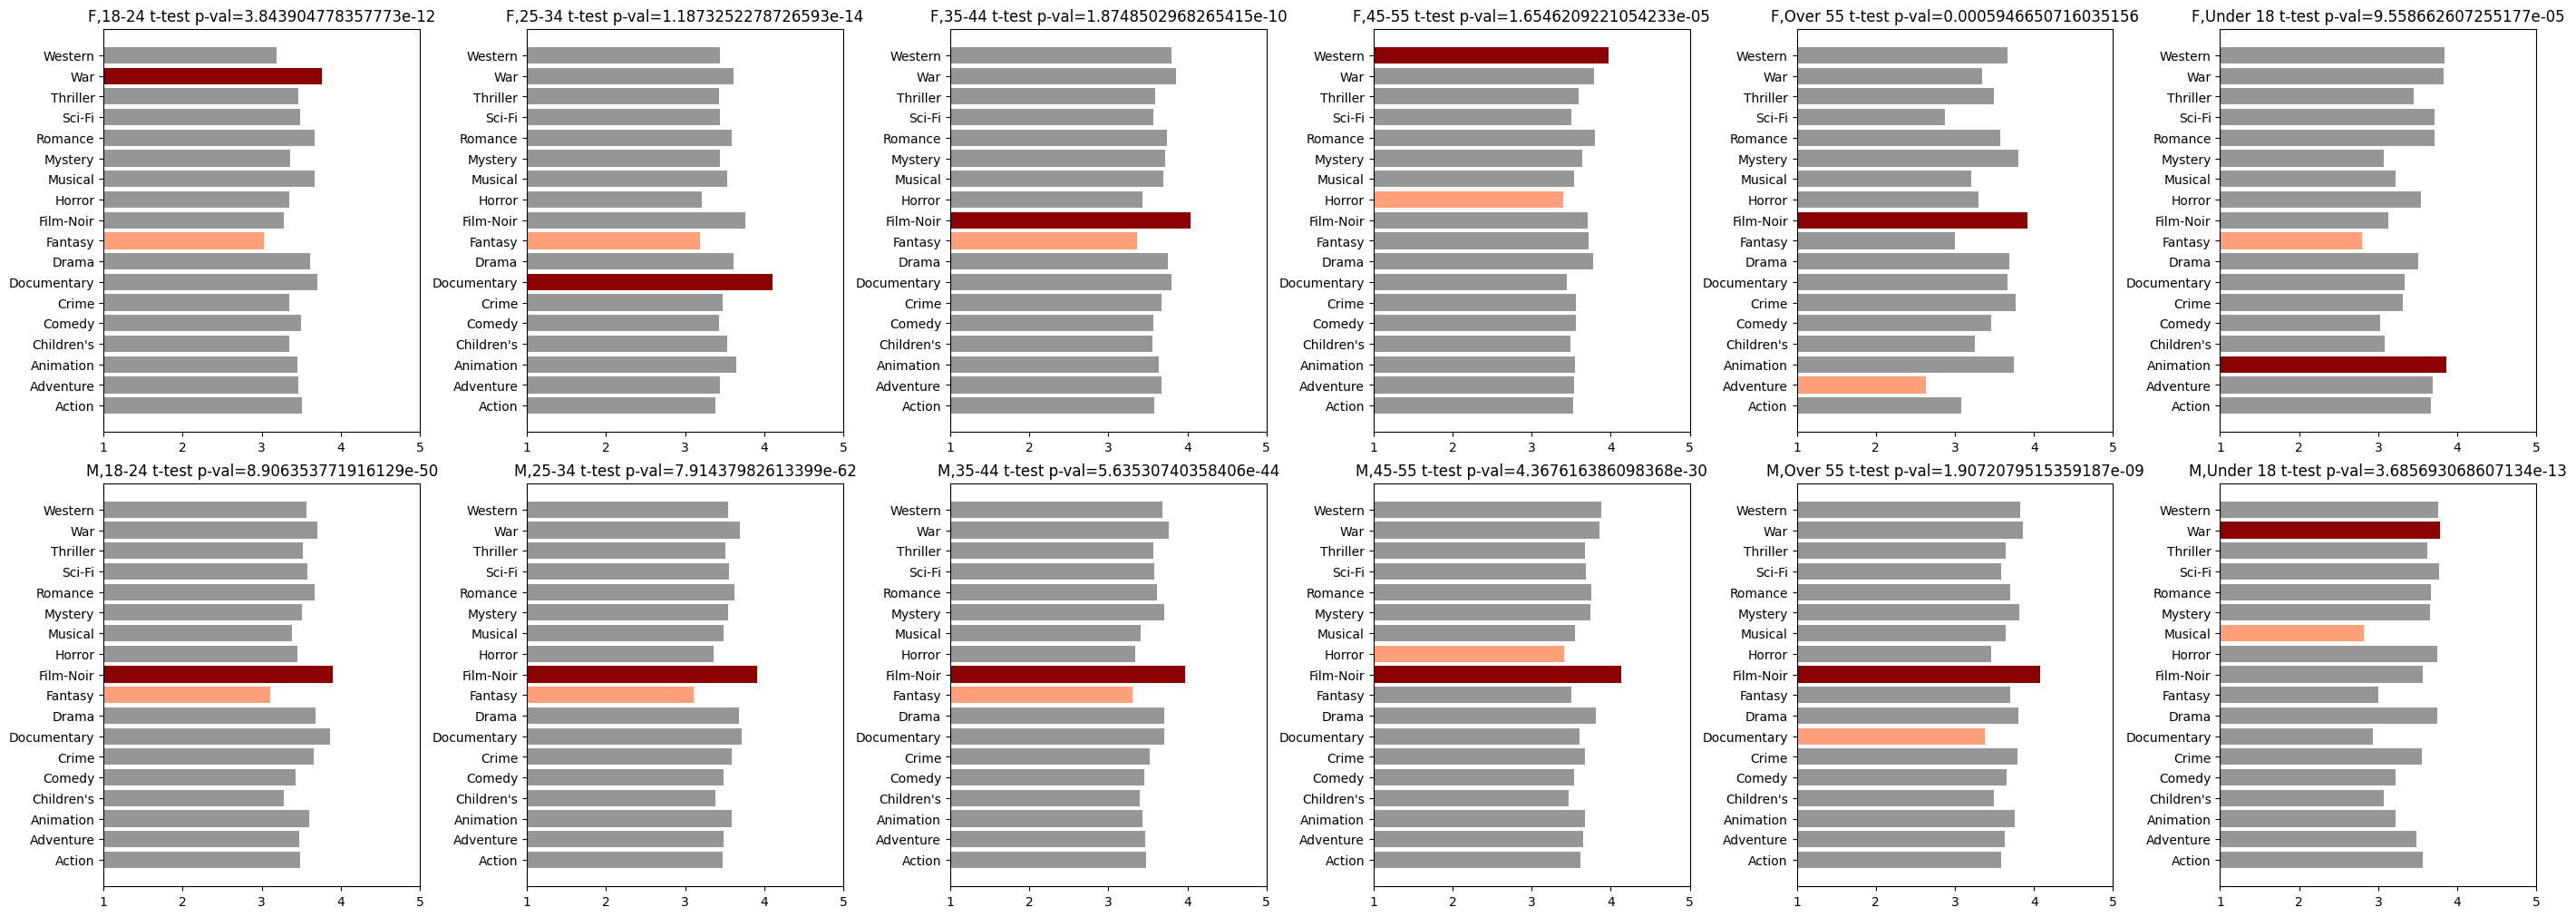

In [ ]:
#age and gender combined - mean rating per genre
from scipy.stats import f_oneway #for one way ANOVA

genre = ["Action","Adventure","Animation","Children's","Comedy","Crime",
         "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical",
         "Mystery","Romance","Sci-Fi","Thriller","War","Western"]

df.sort_values(by='user_id')[['user_id','rating','age','gender']+genre].head()
# Group the dataframe so that each user only has 1 rating for each genre

df_grouped = (df.groupby(['user_id', 'gender', 'age_range']+genre).mean()
                .reset_index()[['user_id', 'gender', 'age_range', 'rating']+genre])

fig, axes = plt.subplots(figsize=(28,10), constrained_layout=True)

for i,(group,frame) in enumerate(df_grouped.groupby(['gender', 'age_range'])):
  mean=[]
  age_list = []
  for g in genre:
    mean.append(frame[frame[g]==1]['rating'].mean())

    age_list.append(frame[frame[g]==1]['rating'].reset_index(drop=True))
    #print(len(age_list))

  anova_test = f_oneway(age_list[0],age_list[1],age_list[2],age_list[3],age_list[4],age_list[5],age_list[6],age_list[7],age_list[8],age_list[9],age_list[10],age_list[11],age_list[12],age_list[13],age_list[14],age_list[15],age_list[16],age_list[17])

  plt.subplot(2,6,i+1)

  colors = ["#969696" for i in range(len(genre))]

  # find the index of the maximum and minimum value
  max_idx = np.argmax(mean)
  min_idx = np.argmin(mean)

  # set the color of the maximum and minimum bars
  colors[max_idx] = '#8B0000'  # dark red
  colors[min_idx] = '#FFA07A'  # light red

  # since the genre labels are long, it makes more sense to use horizontal bars here
  plt.barh(genre,mean,color=colors)

  plt.xlim(1,5)
  plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
  plt.title(','.join(group)+' t-test p-val='+str(anova_test.pvalue))

We conducted an ANOVA test for each demographic group to see if the ratings are statistically different, finding that the p-values for all demographic groups are extremely small, meaning that the ratings for each genre are statistically different. Despite the limitations of the ANOVA test, we use this information to move onto the modelling stage of Milestone 3.

# Modelling

Based on our data exploration, we are ready to move towards building a predictive model. First, we began with selecting our features. These choices were informed by the inspection, visualisation, and preliminary analysis we completed in the previous sections.

## Feature Selection and Engineering

Our feature selection process is detailed in Milestone 3, but in summary, we chose as our features:

*Information about the user*
1. Gender - to be converted to binary
2. Age - kept as continuous
3. Occupation - grouping occupations into 5 categories and included as one-hot encoding

*Information about the movie*
4. Release year - accounting for possible confounder
5. Genres - one-hot encoded from original dataset

## Target Variable

Since our model is designed to predict a user's rating for a movie they have never seen before, our labels in this case are the ratings from our processed dataset.

In milestone 3, we tested various models on two different labels -
1. rating
2. deviation of a movie rating from the mean rating of the movie, which we calculated using the ratings from the original dataset for each movie.

This way we thought we might be able to have a better measure of the preference of the specific user, inherently taking into account the quality of the movie.

## Pre-processing

In [ ]:
new_df = pd.read_csv(path+'MS3Prep.csv')
new_df

,Unnamed: 0,user_id,movie_id,rating,age,gender,occupation,zip_code,movie_title,Action,...,War,Western,year,movie_avg,dev_mean,sciences,arts,services,corporate,unemployed
0,0,196,242,3,49,M,writer,55105,Kolya (1996),0,...,0,0,1997.0,3.991453,-0.991453,0,1,0,0,0
1,1,186,302,3,39,F,executive,00000,L.A. Confidential (1997),0,...,0,0,1997.0,4.161616,-1.161616,0,0,0,1,0
2,2,22,377,1,25,M,writer,40206,Heavyweights (1994),0,...,0,0,1994.0,2.153846,-1.153846,0,1,0,0,0
3,3,244,51,2,28,M,technician,80525,Legends of the Fall (1994),0,...,1,1,1994.0,3.456790,-1.456790,1,0,0,0,0
4,4,166,346,1,47,M,educator,55113,Jackie Brown (1997),0,...,0,0,1997.0,3.642857,-2.642857,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99985,99985,880,476,3,13,M,student,83702,"First Wives Club, The (1996)",0,...,0,0,1996.0,3.018750,-0.018750,0,0,0,0,1
99986,99986,716,204,5,36,F,administrator,44265,Back to the Future (1985),0,...,0,0,1985.0,3.834286,1.165714,0,0,0,1,0
99987,99987,276,1090,1,21,M,student,95064,Sliver (1993),0,...,0,0,1993.0,2.405405,-1.405405,0,0,0,0,1
99988,99988,13,225,2,47,M,educator,29206,101 Dalmatians (1996),0,...,0,0,1996.0,2.908257,-0.908257,0,0,1,0,0


In [ ]:
new_df['gender'] = (new_df['gender']=="M")*1
new_df['movie_avg'] = new_df['movie_avg']
new_df.head()

,Unnamed: 0,user_id,movie_id,rating,age,gender,occupation,zip_code,movie_title,Action,...,War,Western,year,movie_avg,dev_mean,sciences,arts,services,corporate,unemployed
0,0,196,242,3,49,1,writer,55105,Kolya (1996),0,...,0,0,1997.0,3.991453,-0.991453,0,1,0,0,0
1,1,186,302,3,39,0,executive,00000,L.A. Confidential (1997),0,...,0,0,1997.0,4.161616,-1.161616,0,0,0,1,0
2,2,22,377,1,25,1,writer,40206,Heavyweights (1994),0,...,0,0,1994.0,2.153846,-1.153846,0,1,0,0,0
3,3,244,51,2,28,1,technician,80525,Legends of the Fall (1994),0,...,1,1,1994.0,3.456790,-1.456790,1,0,0,0,0
4,4,166,346,1,47,1,educator,55113,Jackie Brown (1997),0,...,0,0,1997.0,3.642857,-2.642857,0,0,1,0,0


In [ ]:
features = ['age','gender','year','movie_avg']
train_X, test_X, train_y, test_y = train_test_split(new_df[features],new_df[['rating']],random_state=0)

scaler = MinMaxScaler()
scaled_train_x = scaler.fit_transform(train_X)
scaled_test_x = scaler.transform(test_X)

## Model Comparisons

In milestone 3, we have tried various regression models with

* rating and
* deviation of a movie rating from the mean rating of the movie

as two possible options of the target variable. We kept all the covariates -- age, gender, occupation -- as well as movie genre and release year as features used for prediction. Here is a summary of the performance of the regression models:

In [ ]:
metrics_regression = pd.read_csv(path+'metrics.csv')
metrics_regression.sort_values(by='Test R Squared')

,Model (Regression),Target Variable,Test MAE,Test R Squared
0,Linear,dev_mean,0.798357,0.001720
1,Polynomial (deg=2),dev_mean,0.794481,0.009983
6,KNN,dev_mean,0.791915,0.016504
7,Random Forest,dev_mean,0.767332,0.072196
3,Linear Ridge,rating,0.798390,0.213415
2,Linear Lasso,rating,0.798221,0.213590
5,Polynomial Lasso,rating,0.796082,0.218514
4,Polynomial (deg=2),rating,0.794168,0.220577


### Regressor Baseline

It can be observed that the R^2 score for the test dataset is unsatisfactory. To confirm this, we would want to establish a baseline for the models. One trivial baseline for regression models is to predict the mean.

In [ ]:
print("Predicting with the mean of the train set: ")
print("Mean Absolute Error (MAE)",
       mean_absolute_error(test_y, np.full(len(test_y),train_y.mean())))
print("R-squared Score (R2)",
       r2_score(test_y, np.full(len(test_y),train_y.mean())))
print("")
print("Predicting with the mean of the test set: ")
print("Mean Absolute Error (MAE)",
       mean_absolute_error(test_y, np.full(len(test_y),test_y.mean())))
print("R-squared Score (R2)",
       r2_score(test_y, np.full(len(test_y),test_y.mean())))

Predicting with the mean of the train set: 
Mean Absolute Error (MAE) 0.9459768131994618
R-squared Score (R2) -6.695250338317749e-05

Predicting with the mean of the test set: 
Mean Absolute Error (MAE) 0.9449418886545565
R-squared Score (R2) 0.0


All of the regression models, therefore, do indeed pass the trivial baseline. However, it must be observed that when we try to use the mean value of the ratings in the training set to predict ratings for features that the model has never seen before, we get a negative R^2 value, which indicates an extremely poor fit that's worse than a horizontal line. This may suggest that there is a high degree of variability in the data or that there are no clear patterns or trends in the ratings that can be appropriately captured by the regression models. This results in a low R-squared score, indicating that the model is not explaining much of the variance in the data.

With this in mind, we turned to classification models.

### Classifier Baseline 1: Predicting with random rating

Likewise, let us do a summary of the performance of the classifiers that we examined in Milestone 3. We also add in KNN classifier in this milestone.

In [ ]:
# KNN classifier

knn = KNeighborsClassifier()

param_grid = dict(n_neighbors=np.arange(1,5))
grid = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy')
grid.fit(scaled_train_x,train_y.values.ravel())

y_pred = grid.predict(scaled_test_x)

print("Accuracy score: {}".format(accuracy_score(test_y,y_pred)))
print("F1 score: {}".format(f1_score(test_y,y_pred, average='weighted')))

Accuracy score: 0.32278582286582924
F1 score: 0.3222882667657324


In [ ]:
metrics_classification = pd.read_csv(path+'metrics2.csv')
metrics_classification.sort_values(by='Accuracy')

,Model (Classification),Target Variable,Accuracy,F1
2,KNN,rating,0.322786,0.322288
0,Logistic Regression,rating,0.390551,0.344863
1,Random Forest,rating,0.399712,0.367139


In [ ]:
# Logistic Regression

# Setting parameter grid for grid search
param_grid = {"C": np.logspace(-3,3,7),
               "penalty":["l1","l2"]}
logreg = LogisticRegression(max_iter=100000)

# defining grid search with 5-fold cross validation
grid_search = GridSearchCV(logreg, param_grid,cv=5)

grid_search.fit(scaled_train_x,train_y.values.ravel())

y_pred = grid_search.predict(scaled_test_x)

print("Accuracy score: {}".format(accuracy_score(test_y,y_pred)))
print("F1 score: {}".format(f1_score(test_y,y_pred, average='weighted')))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Accuracy score: 0.39055124409952796
F1 score: 0.34486312555758425


We set our baseline using the accuracy metric.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# define model
model = LogisticRegression(C=grid_search.best_params_['C'],penalty=grid_search.best_params_['penalty'],max_iter=100000)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, scaled_train_x,train_y, scoring='accuracy', cv=cv)
# force scores to be positive
scores = abs(scores)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Mean Accuracy: 0.391 (0.006)


In [ ]:
random_arr = []

for i in range(30):
  random_score = (np.random.randint(1,6,len(scaled_test_x)))
  random_arr.append(accuracy_score(test_y, random_score))

stats.ttest_ind(scores, random_arr)

Ttest_indResult(statistic=155.1604522441115, pvalue=1.1552212437278044e-77)

### Classifier Baseline 2: Predicting with mode rating

In [ ]:
train_y.value_counts()

rating
4         25638
3         20389
5         15829
2          8541
1          4595
dtype: int64

In [ ]:
# Calculate the most frequent rating in the training dataset and the accuracy of
# the prediction if we predict every rating in the test set as this mode value
mode_rating = train_y.mode()
pct = (test_y.value_counts()[mode_rating.values[0][0]]/test_y.count()).values[0]

pct

0.34130730458436676

In [ ]:
mode_arr = np.full(30, pct)
stats.ttest_ind(scores, mode_arr)

<ipython-input-70-587f0efd83eb>:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.ttest_ind(scores, mode_arr)


Ttest_indResult(statistic=44.64433686703538, pvalue=1.3063603606307836e-46)

Our logistic regression model passes both baselines with a small p value << 0.05.

### Discussion: Movie rating as a variable

In summary, it seems that while movie ratings are technically continuous variables, they are typically represented as discrete values, which may make them better suited to classification models.

According to various literature, movie ratings from 1-5 are considered to be an example of an **ordinal categorical variable** because the values have a natural order or hierarchy. In other words, the rating of 5 is considered to be "better" or "higher" than a rating of 4, which is considered to be better than a rating of 3, and so on.

However, the difference between an ordinal categorical variable and a quantitative variable is that for the former, the differences between the individual rating categories are not necessarily equal. For example, the difference between a rating of 1 and a rating of 2 may not be the same as the difference between a rating of 3 and a rating of 4. This lack of uniformity is not consistent with a quantitative, or numerical, variable.

Additionally, the movie ratings in this dataset are not based on a numerical measurement: While the ratings are represented using numerical values, they do not represent a measurable quantity like height, weight, or time. Instead, they represent an individual's subjective evaluation of a movie's quality. Each rating category represents a distinct and separate value that is not connected by a continuous range of possible values (e.g. there is no score of "3.5").

To further illustrate this point, consider applying arithmetic operations to the target variables. On a 1-5 scale, suppose someone rates one movie as 2 and and another as 4. Then it is difficult to imagine what it would mean to say that they liked one movie 'twice as much' as the other. Similarly, if one person gives scores 3 and 3 and another person gives the same two movies scores 1 and 5, it is difficult to imagine the two people had exactly the same overall satisfaction watching the two movies. This shows that while the labels appear to be numerical, we cannot attribute numerical characteristics to the scores.

## Random Forest: Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

features = ['age','gender','year','movie_avg']
train_X, test_X, train_y, test_y = train_test_split(new_df[features],new_df['rating'],random_state=0)

scaler = MinMaxScaler()
scaled_train_x = scaler.fit_transform(train_X)
scaled_test_x = scaler.transform(test_X)

gump = RandomForestClassifier(max_depth = 10, min_samples_split =10).fit(scaled_train_x, train_y)

y_pred = gump.predict(scaled_test_x)

print('Accuracy',accuracy_score(test_y,y_pred))
print('F1 score', f1_score(test_y,y_pred,average='weighted'))


Accuracy 0.39967197375790064
F1 score 0.36713875769304605


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# define model
model = RandomForestClassifier(max_depth = 10,min_samples_split=10)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, scaled_train_x,train_y, scoring='accuracy', cv=cv)
# force scores to be positive
scores = abs(scores)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.397 (0.006)


These results show that our random forest classifier not only has the highest accuracy score of all our models, but also clears both of our classifier baselines. This reinforces the idea that there are consistent patterns in rating behaviour in our data that enables this prediction of ratings. We can now use this model to explore what these patterns are in greater detail.

We can do this by looking at feature importance, to see which variables from our model contributed most to helping with rating predictions.

In [ ]:
#look at average feature importance over 10 random forest iterations

#run one outside to initialize array
features = ['age','gender','year','movie_avg']
train_X, test_X, train_y, test_y = train_test_split(new_df[features],new_df['rating']) #different train-test splits

scaler = MinMaxScaler()
scaled_train_x = scaler.fit_transform(train_X)
scaled_test_x = scaler.transform(test_X)

gump = RandomForestClassifier(max_depth = 10, min_samples_split =10).fit(scaled_train_x, train_y)

tot_feat_imp = gump.feature_importances_

for ii in range(9):
  features = ['age','gender','year','movie_avg']
  train_X, test_X, train_y, test_y = train_test_split(new_df[features],new_df['rating']) #different train-test splits

  scaler = MinMaxScaler()
  scaled_train_x = scaler.fit_transform(train_X)
  scaled_test_x = scaler.transform(test_X)

  gump = RandomForestClassifier(max_depth = 10, min_samples_split =10).fit(scaled_train_x, train_y)

  tot_feat_imp = tot_feat_imp + gump.feature_importances_

avg_feat_imp = tot_feat_imp/10

Text(0.5, 1.0, 'Avg Feature Importance')

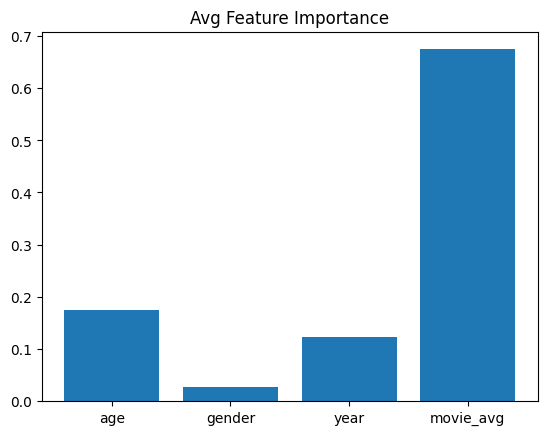

In [ ]:
ax = plt.subplot()
ax.bar(features, height = avg_feat_imp)
ax.set_title('Avg Feature Importance')

One of the things that immediately stands out from this plot is the fact that gender scores very low; gender appears to be quite a poor predictor of movie rating. This would be an interesting finding as gender is something that we would stereotypically expect to influence movie preference. However, we cannot actually make any conclusions based on this result, because we have not yete included information on the genre of the movie.

In [ ]:
#Single RF with genres

genres = list(new_df.columns[9:27])

features = ['age','gender','year','movie_avg'] + genres
print(features)

train_X, test_X, train_y, test_y = train_test_split(new_df[features],new_df['rating'],random_state=0)

scaler = MinMaxScaler()
scaled_train_x = scaler.fit_transform(train_X)
scaled_test_x = scaler.transform(test_X)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

gump = RandomForestClassifier(max_depth = 10, min_samples_split =10)
gump.fit(scaled_train_x,train_y)

y_pred = gump.predict(scaled_test_x)
accuracy_score(test_y,y_pred)

['age', 'gender', 'year', 'movie_avg', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


0.3923913913113049

In [ ]:
#look at average feature importance over 10 random forest iterations, with genre features

#run one outside to initialize array
features = ['age','gender','year','movie_avg'] + genres
train_X, test_X, train_y, test_y = train_test_split(new_df[features],new_df['rating']) #different train-test splits

scaler = MinMaxScaler()
scaled_train_x = scaler.fit_transform(train_X)
scaled_test_x = scaler.transform(test_X)

gump = RandomForestClassifier(max_depth = 10, min_samples_split =10).fit(scaled_train_x, train_y)

tot_feat_imp = gump.feature_importances_

for ii in range(9):
  features = ['age','gender','year','movie_avg'] + genres
  train_X, test_X, train_y, test_y = train_test_split(new_df[features],new_df['rating']) #different train-test splits

  scaler = MinMaxScaler()
  scaled_train_x = scaler.fit_transform(train_X)
  scaled_test_x = scaler.transform(test_X)

  gump = RandomForestClassifier(max_depth = 10, min_samples_split =10).fit(scaled_train_x, train_y)

  tot_feat_imp = tot_feat_imp + gump.feature_importances_

avg_feat_imp = tot_feat_imp/10

Text(0.5, 1.0, 'Avg Feature Importance')

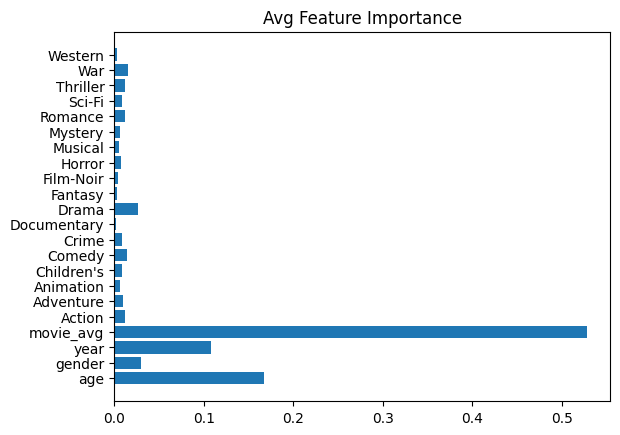

In [ ]:
ax = plt.subplot()
bars = ax.barh(features, width = avg_feat_imp)
ax.set_title('Avg Feature Importance')


In [ ]:
#Try different model for each genre - to include genre information that way

gen_feat_imps = np.empty((18,4))

for ii, genre in enumerate(genres):
  features = ['age','gender','year','movie_avg']
  rows = new_df[new_df[genre] == 1]
  train_X, test_X, train_y, test_y = train_test_split(rows[features],rows['rating'])

  scaler = MinMaxScaler()
  scaled_train_x = scaler.fit_transform(train_X)
  scaled_test_x = scaler.transform(test_X)

  gump = RandomForestClassifier(max_depth = 10, min_samples_split =10).fit(scaled_train_x, train_y)

  gen_feat_imps[ii,:] = gump.feature_importances_

print(gen_feat_imps)


[[0.3048474  0.04182241 0.14466665 0.50866353]
 [0.36440095 0.04808671 0.14520417 0.44230817]
 [0.45891792 0.06378865 0.12126284 0.35603059]
 [0.40452554 0.05891566 0.1429853  0.3935735 ]
 [0.2710215  0.02958343 0.14113936 0.5582557 ]
 [0.36805432 0.05427019 0.12407062 0.45360488]
 [0.45355317 0.06649927 0.14170651 0.33824106]
 [0.25145631 0.03968553 0.13895902 0.56989914]
 [0.53783839 0.07147245 0.13172315 0.25896601]
 [0.5670944  0.06450909 0.12218091 0.2462156 ]
 [0.41830167 0.05463871 0.1611737  0.36588592]
 [0.4851544  0.0579368  0.15853898 0.29836982]
 [0.42409936 0.05687412 0.15353082 0.36549569]
 [0.3384836  0.04028381 0.15002202 0.47121056]
 [0.37941641 0.05567482 0.14051156 0.42439722]
 [0.28530302 0.04484509 0.13762278 0.53222911]
 [0.43049134 0.05735628 0.14285249 0.36929989]
 [0.54607025 0.0733612  0.11998206 0.26058649]]


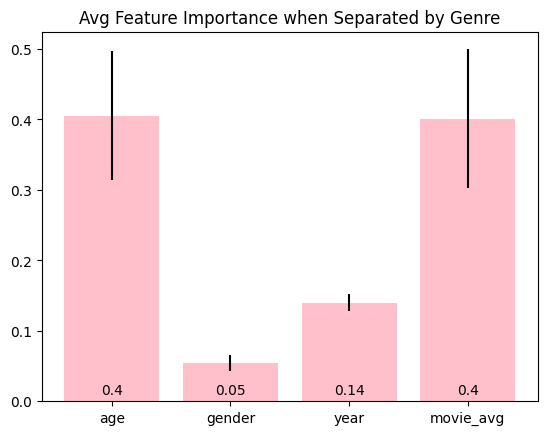

In [ ]:
avg_gen_imps = np.mean(gen_feat_imps,0)
std_gen_imps = np.std(gen_feat_imps,0)

ax = plt.subplot()
bars = ax.bar(features, height = avg_gen_imps, yerr=std_gen_imps,color = 'pink')

ax.set_title('Avg Feature Importance when Separated by Genre')

# Loop through the bars and add annotations
for bar in bars:
   height = bar.get_height()
   ax.annotate(f'{height.round(2)}', xy=(bar.get_x() + bar.get_width() / 2, 0), xytext=(0,3),
   textcoords="offset points", ha='center', va='bottom')

A more detailed look:

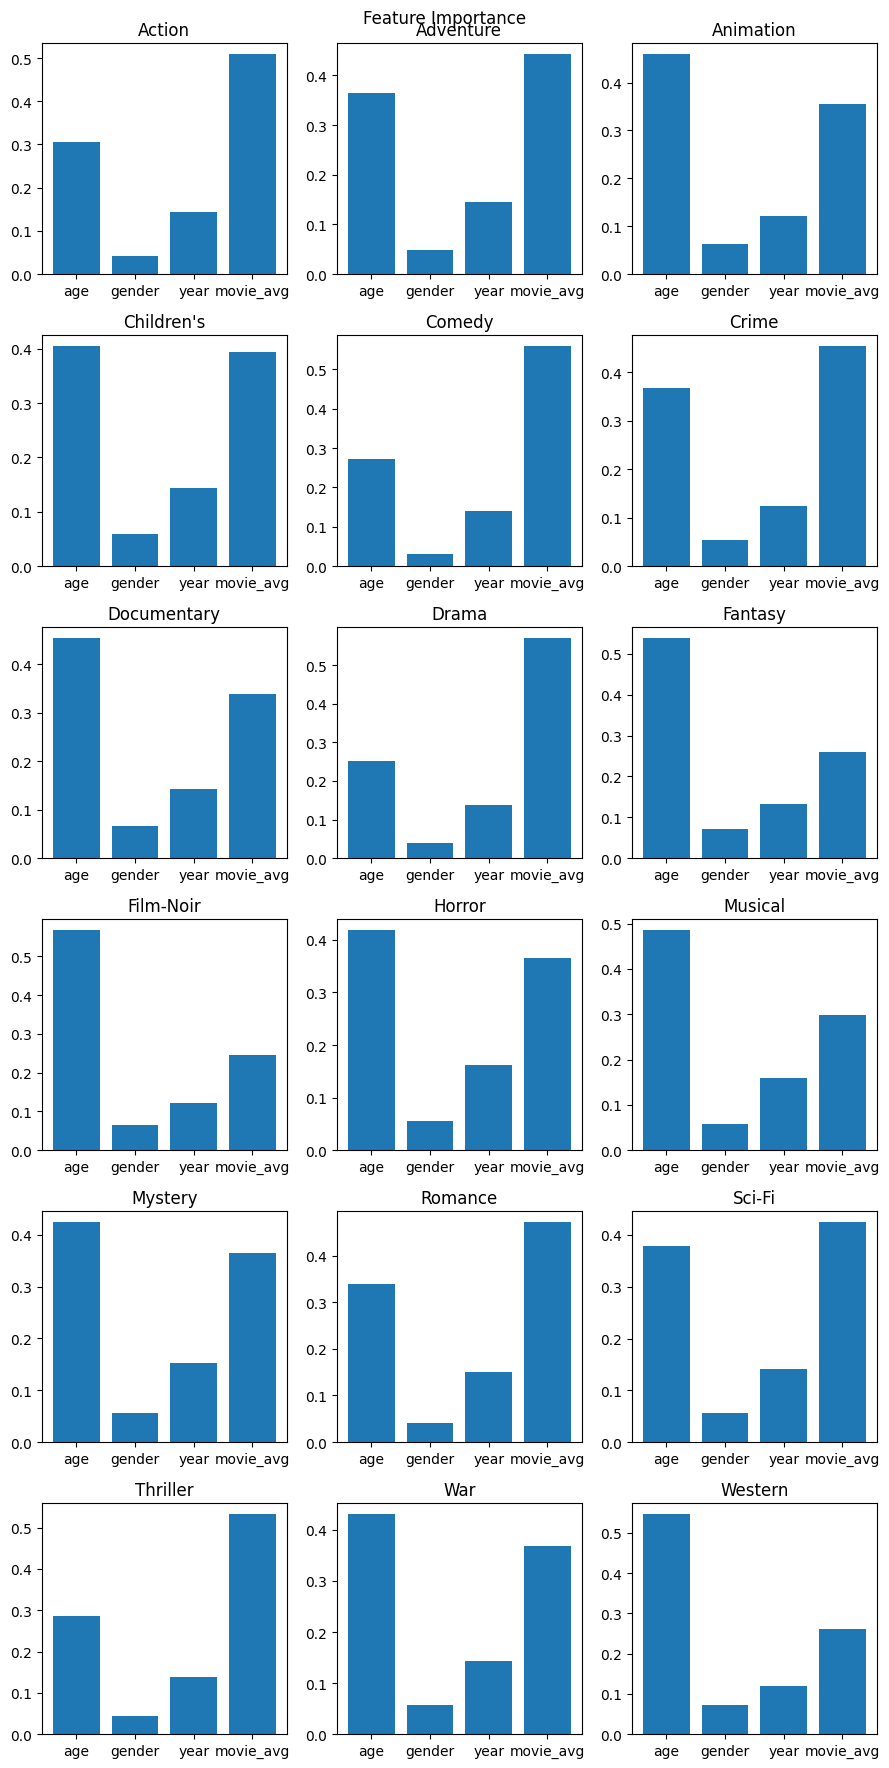

In [ ]:
plt.figure(figsize = (9,18))

for ii, genre in enumerate(genres):
  ax = plt.subplot(6,3,ii+1)

  ax.bar(features, height = gen_feat_imps[ii,:])

  ax.set_title(genre)
  plt.tight_layout()
  plt.suptitle('Feature Importance')

What we see quite clearly, both in the plot for averages and persistent through each genre plot, is that age is a far better predictor as a demographic feature than gender, which has a very low feature importance, of 0.05 on average. This is an interesting finding because it tells us that age may be a more important determinant of movie preferences than gender. This makes sense when we think about how some movie types are targeted at certain age groups, for instance, animated and Children's movies are targeted at children, many Romances and Comedies at teenagers/young adults, documentaries are for older people, etc. However, what is quite counter-intuitive is how low the importance of gender is, because that tells us that movie preference might not vary very much across gender. This is contrary to stereotypical gender biases, which might often classify certain genders as more 'masculine' or 'feminine' and where marketing might target females or males for certain types of movies.

# Limitations

## Skewed Gender Distribution

As we saw in our initial data inspection, our dataset is heavily skewed towards male users.

In [ ]:
dfUser.value_counts('gender')

gender
M    670
F    273
dtype: int64

In [ ]:
df.value_counts('gender')

gender
M    74252
F    25738
dtype: int64

Almost 70% of the users we have are male, and these male users account for 75% of all the ratings in the dataset (so they count for a disproprotionate share of the total ratings).

With such few female ratings compared to male, there may not be enough data to be representative of these gender groups in our analysis, which may compromise the accuracy of our results.

## Uneven Genre Distribution

Like with gender, our dataset also had an uneven distribution of movies across the 18 genres. As we saw in our genre visualisations, some genres had lots of movies and ratings while others had very few.

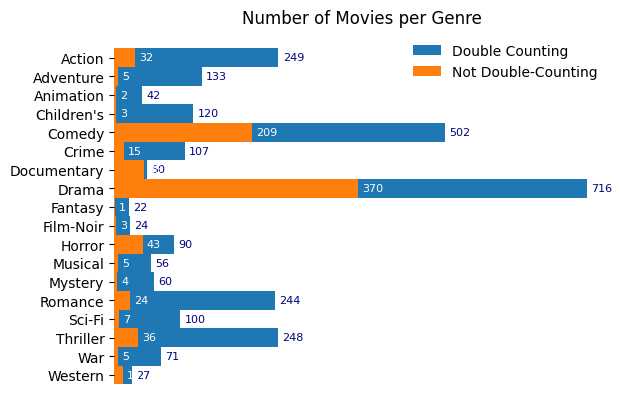

In [ ]:
movie_genre_categories_all = df_unique_movies.groupby('genre_string').count().sort_values('movie_title', ascending=False)[['movie_title']]
movie_genre_categories_single = movie_genre_categories_all.loc[df.columns[7:-2]].sort_index(ascending=False) #return rows for single genres only, pulled from genre columns of original dataframe

bars1 = plt.barh(movies_by_genre.index, movies_by_genre.values, height=1);
plt.bar_label(bars1, fontsize = 8, padding = 3, color = 'navy');

bars2 = plt.barh(movie_genre_categories_single.index, movie_genre_categories_single.movie_title, height=1);
plt.bar_label(bars2, fontsize = 8, padding = 3, color = 'white');
plt.legend(['Double Counting', 'Not Double-Counting'], frameon=False, fontsize=10)

ax = plt.gca()
ax.spines[:].set_visible(False);
ax.set_xticks([]);
ax.grid(False)
ax.set_title("Number of Movies per Genre");

It can be clearly seen that genres like Fantasy and Film have very few movies, and even less if we do not double count movies in our analysis (ie. only take the 822 movies that have a single genre). As a result, we will have very few ratings for these genres, and combined with our gender skew, we may have even fewer female ratings for certain genres. This means that the results we observed when looking at differences in ratings for demographic groups across genres may not be very accurate.

## Mean Movie Rating as a Proxy for Quality




One limitation of our study was also that we used, as a proxy for movie quality, the average of ratings for that movie from within our dataset. This would have reduced the statistical power of our model slightly, because contained within the movie_avg feature we were using to try and predict ratings, was the rating we were trying to predict. This may have inflated the correlation between movie_avg and ratings that we see throughout. In an ideal scenario, we would have used movie ratings from an external source like Rotten Tomatoes as the metric for movie quality, however, we did not have time to implement the web-scraping for that.

## Selection Bias

What is perhaps the biggest limitation in our dataset is the fact that not all users have rated the same movies, and so our dataset of ratings does not entirely capture movie preference. It provides insight into how people rate movies they choose to rate from movies they have watched. However, the choice of movies to watch as well as the choice of movies to rate is left to the user, and not accounted for in the data, which means there is a certain selection bias, because people may have only chosen to rate movies they really liked or disliked.

# Findings and Conclusion

Our project looked into movie ratings data to investigate whether there are consistent trends in movie preference based on certain demographic features, or whether the ratings are random. This was tested by trying to create a predictor model (using classification) for movie rating given: age and gender of the user; the genre, release year and quality (avg rating) of the movie. Our classification models using logistic regression and random forest classification cleared both our trivial baselines, suggesting that the ratings are not completely random, so we can reject our null hypothesis. Random forest was our best performing model based on Accuracy and we could use the Feature Importances within the model to further investigate the patterns that enable prediction. What we see is that age has a much higher feature importance (average 40%) than gender (average 5%), even when the model accounts for movie genre. This is interesting particularly because the low importance of gender in movie taste goes against gender stereotypes.